<a href="https://colab.research.google.com/github/ksb7762-k/Dart-B/blob/main/Credit_Card_Fraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credit Card Fraud Detection: Anomaly Detection Approach
# 신용카드 사기 탐지: 이상 탐지 접근법

신용카드 사기는 심각한 문제이며, 이를 빠르게 감지하는 것이 중요함. 많은 머신러닝 모델이 지도학습(Supervised Learning)에 의존하지만, **이상 탐지(Anomaly Detection)**는 종종 더 효과적일 수 있음. 이는 사기 거래가 매우 드물고, 학습에 필요한 라벨링된 데이터가 제한적인 경우가 많기 때문임.

---

## **📝 지도학습 vs. 이상 탐지의 차이점**

1. **지도학습 (Supervised Learning)**  
   - 라벨링된 데이터(정상 및 사기 거래)를 기반으로 패턴을 학습함.  
   - 모든 클래스에 대해 충분한 데이터가 있는 경우 효과적임.  
   - **⚠️ 단점**  
     - 사기 거래가 드물기 때문에 데이터가 매우 불균형함.  
     - 정상 거래는 잘 감지하지만, 사기 거래 탐지 성능이 떨어질 수 있음.  

2. **이상 탐지 (Anomaly Detection)**  
   - 대량의 사기 사례가 없어도 정상 패턴을 학습하여 이상거래를 탐지함.  
   - 드문 사건(예: 사기) 탐지에 적합함.  
   - **✅ 장점**  
     - 새로운 유형의 사기를 감지할 수 있음.  
     - 라벨링된 데이터가 적어도 효과적으로 동작함.  

---

## **🔍 왜 이상 탐지를 사용하는가?**

- **희귀 이벤트 처리**  
  - 사기는 드문 현상이기 때문에 이상 탐지에 적합함.  
- **새로운 사기 전술에 적응**  
  - 비정상적인 패턴에 집중하여 새로운 사기 유형도 감지 가능.  
- **적은 라벨 데이터**  
  - 지도학습에 비해 더 적은 라벨링 데이터로도 학습 가능.  

---

## **🚀 대표적인 이상 탐지 알고리즘**

1. **Isolation Forest**  
   - 개별 데이터 포인트를 분리하여 이상치를 식별.  
   - 대용량 데이터셋에서도 효율적임.  

2. **One-Class SVM**  
   - 정상 거래의 공간을 모델링하고, 이 범위를 벗어나는 거래를 이상으로 간주함.  

3. **Autoencoders**  
   - 정상 거래를 복원하는 신경망 모델.  
   - 재구성 오류가 큰 데이터는 이상으로 판단함.  

4. **Local Outlier Factor (LOF)**  
   - 데이터의 밀도를 측정하여 주변 밀도가 낮은 데이터를 이상치로 탐지함.  

5. **DBSCAN**  
   - 데이터를 클러스터링하여 어떤 클러스터에도 속하지 않는 데이터를 잠재적 사기로 간주함.  

---

## **📊 데이터셋 설명: 신용카드 사기 탐지 데이터**

### **🗂️ 주요 특징**  
- **Time**  
  - 데이터셋 내에서 첫 거래 이후 경과된 시간(초)  

- **V1 ~ V28**  
  - 비식별화된 주요 특징 (PCA로 변환된 데이터)  

- **Amount**  
  - 거래 금액 (이상 거래 탐지에 중요한 특징)  

- **Class**  
  - 목표 변수 (Target)  
  - `0`: 정상 거래  
  - `1`: 사기 거래  
  - *(비지도 학습 모델에서 평가 시 주로 사용됨)*  


# import libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap  # 커스텀 색상 맵을 만들기 위한 모듈 임포트
import seaborn as sns
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# 데이터를 읽고 이해하기

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/kagglestudy/Credit card Fraud/creditcard.csv')

In [ ]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
df.shape

(284807, 31)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

- 결측치 없음
- 데이터 타입 이상 없음

# EDA

In [ ]:
df.isna().sum()

,0
Time,0
V1,0
V2,0
V3,0
V4,0
V5,0
V6,0
V7,0
V8,0
V9,0


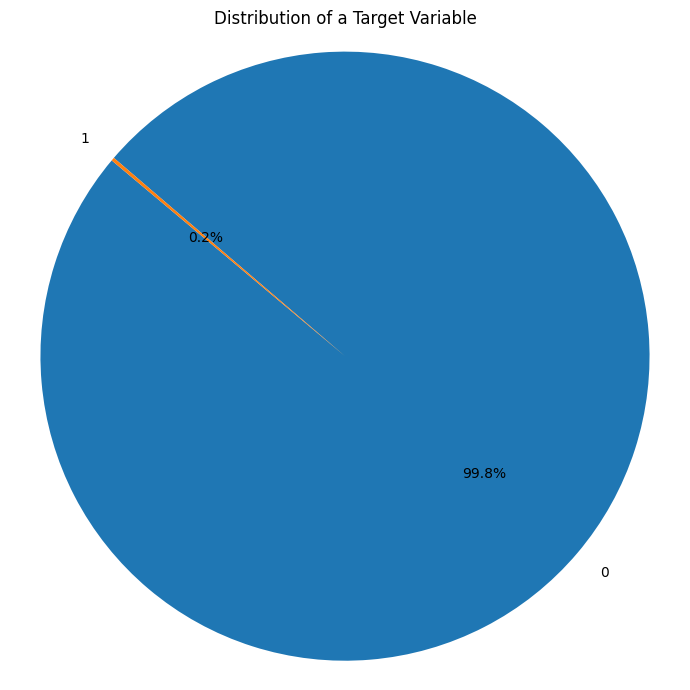

In [ ]:
counts = df.Class.value_counts()

plt.figure(figsize=(7,7))
plt.pie(counts, labels = counts.index, autopct = '%1.1f%%',
        startangle=140)

plt.title('Distribution of a Target Variable')
plt.axis('equal')

plt.tight_layout()
plt.show()

- 우리는 이상징후 (사기 거래)가 데이터셋의 0.2프로에 해당한다는 것을 관찰함

# 피쳐 분포

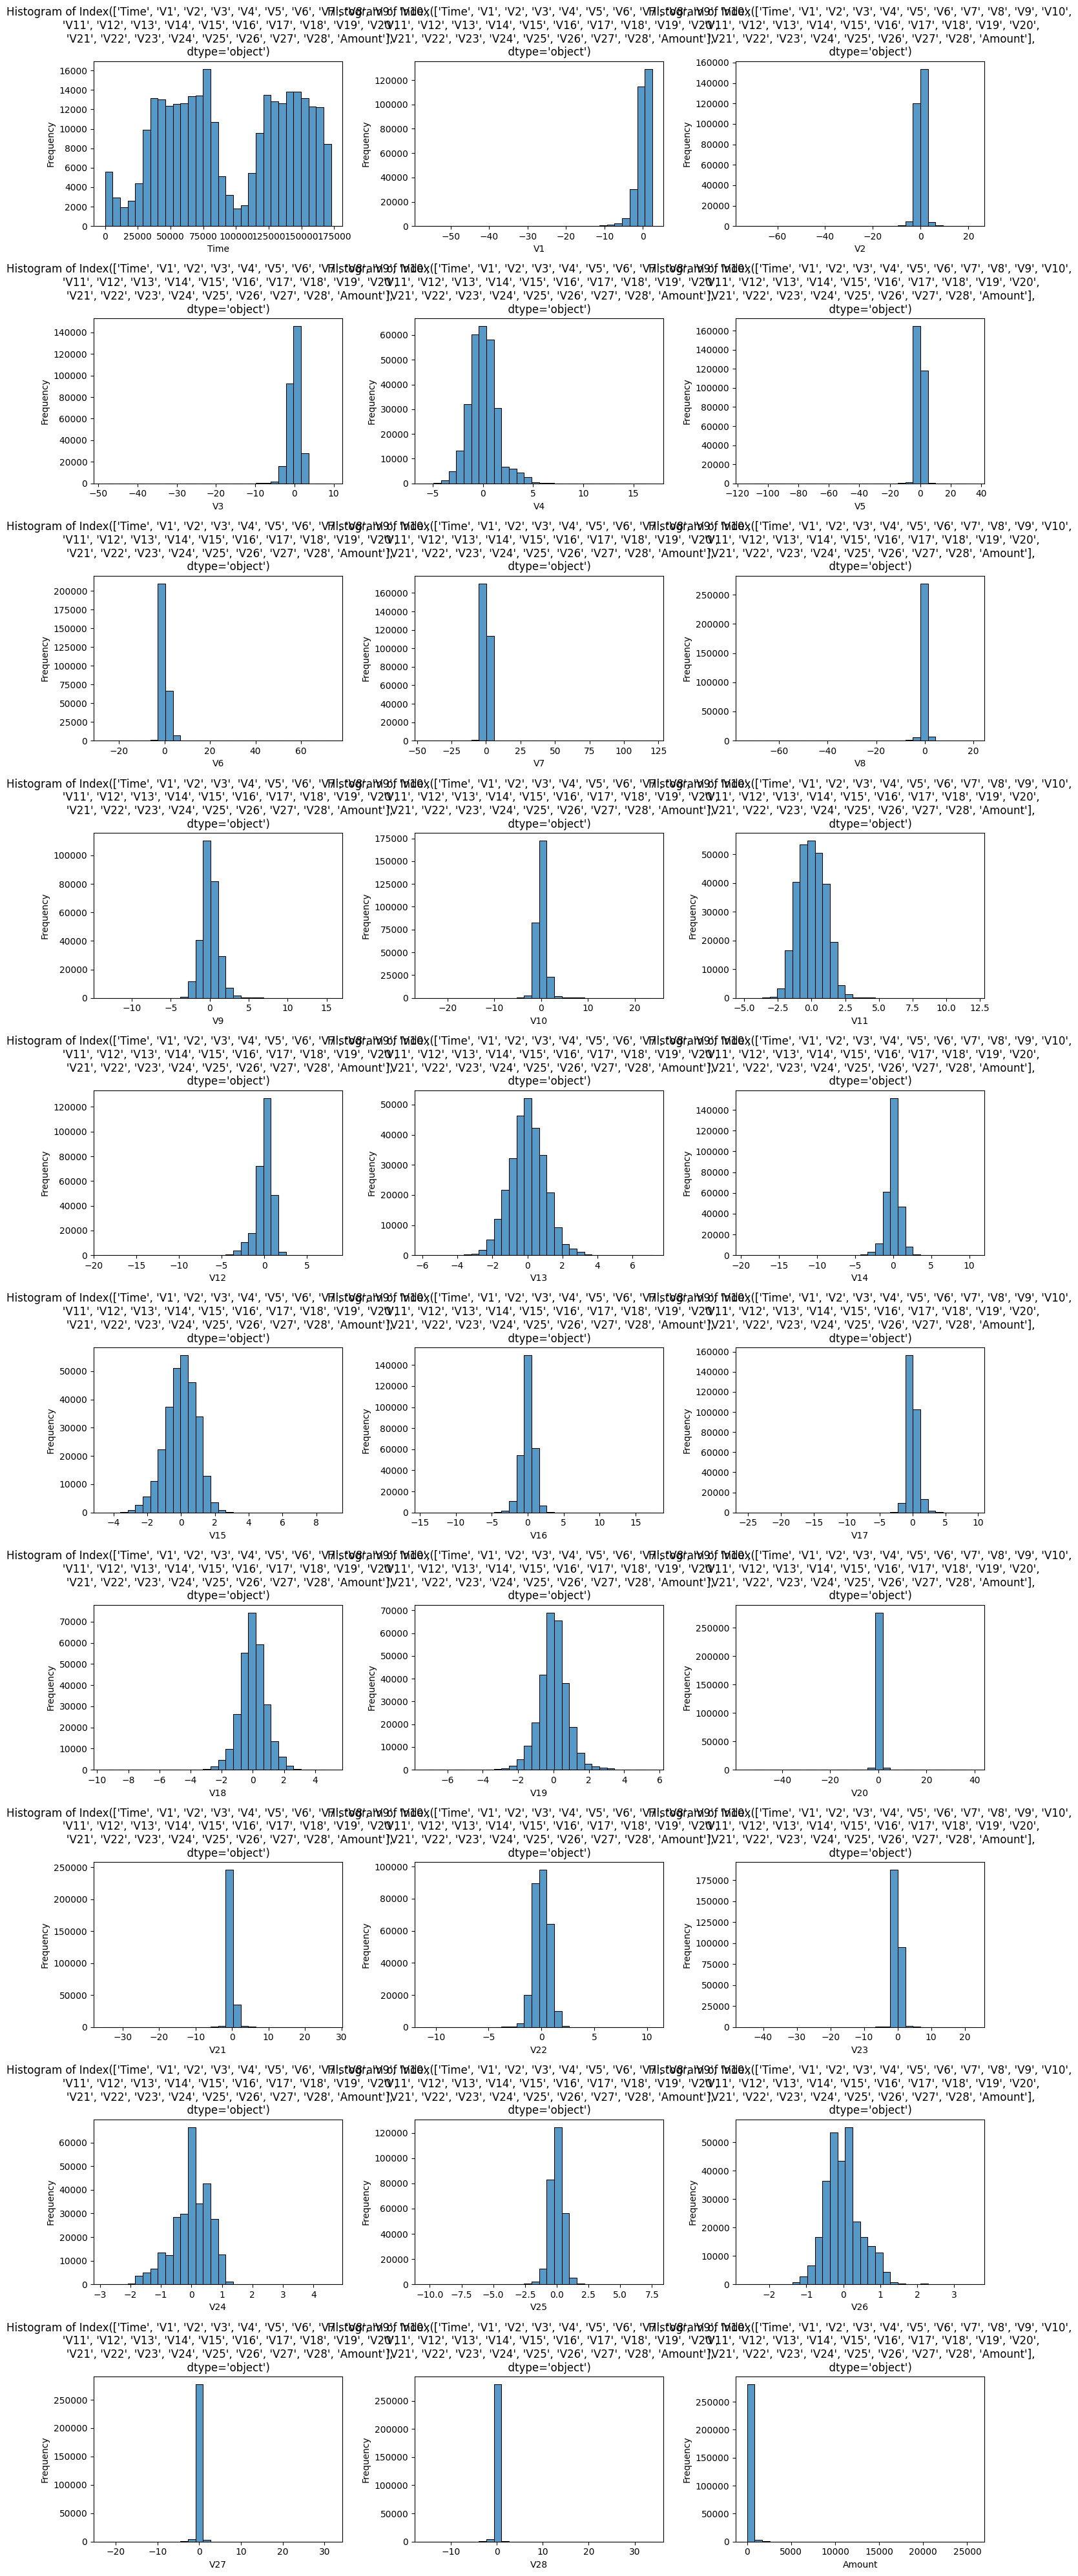

In [ ]:
features = df.columns[:-1] # 타겟 변수를 제외한 모든 피처(독립 변수) 선택

fig, axes = plt.subplots(10, 3, figsize=(15, 40))

axes = axes.flatten()


for i, feature in enumerate(features):
    sns.histplot(df[feature], ax = axes[i], kde = False, bins =30)
    axes[i].set_title(f'Histogram of {features}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# 제목이 겹쳐보이지 않게 간단히 수정

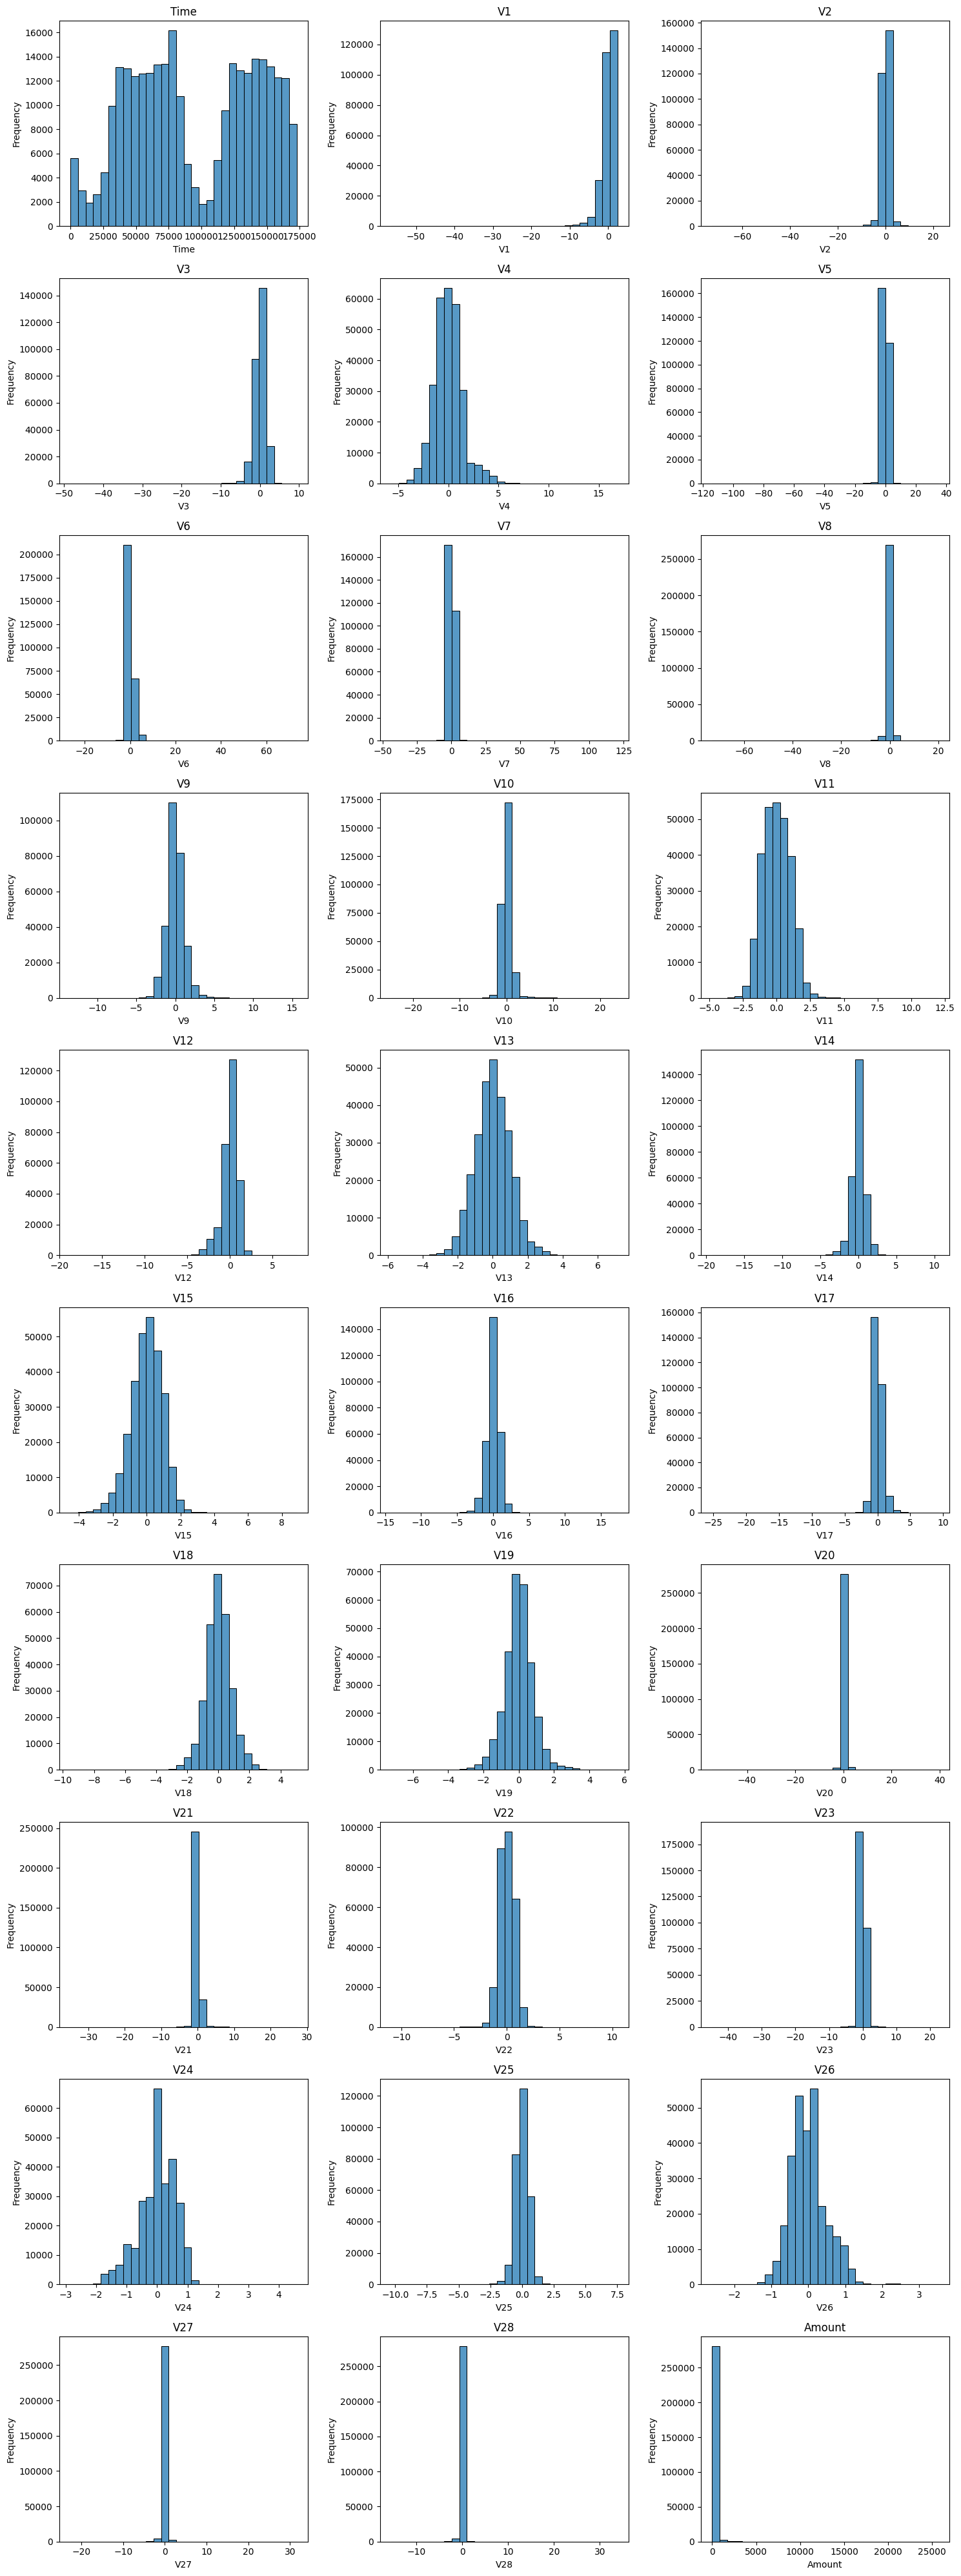

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

features = df.columns[:-1]  # 타겟 변수를 제외한 모든 피처(독립 변수) 선택

fig, axes = plt.subplots(10, 3, figsize=(15, 40))  # 10 x 3 그리드 설정 (총 30개 변수)
axes = axes.flatten()  # 2D 배열을 1D로 변환

for i, feature in enumerate(features):
    sns.histplot(df[feature], ax=axes[i], kde=False, bins=30)
    # 폰트 크기를 줄이고 제목을 간단히 수정
    axes[i].set_title(feature, fontsize=12)
    axes[i].set_xlabel(feature, fontsize=10)
    axes[i].set_ylabel('Frequency', fontsize=10)

plt.tight_layout()
plt.show()


- 관측결과에서 알 수 있듯이, 몇 가지 피쳐는 왜도가 있어서 변형이 필요해 보임

## PCA로 남아있는 피쳐들 변형해보자

In [ ]:
cols = df[['Time', 'Amount']]

pca = PCA()  # PCA 객체 생성 (기본 설정: 모든 주성분 사용)
pca.fit(cols)
X_PCA = pca.transform(cols)

df['V29'] =X_PCA[:, 0]
# X_PCA는 PCA로 변환된 데이터 배열
# [:, 0]은 이 배열에서 첫 번째 주성분만 선택하는 슬라이싱 문법

df['V30'] = X_PCA[:,1]

df.drop(['Time', 'Amount'], axis =1, inplace=True)

# 피쳐 선택

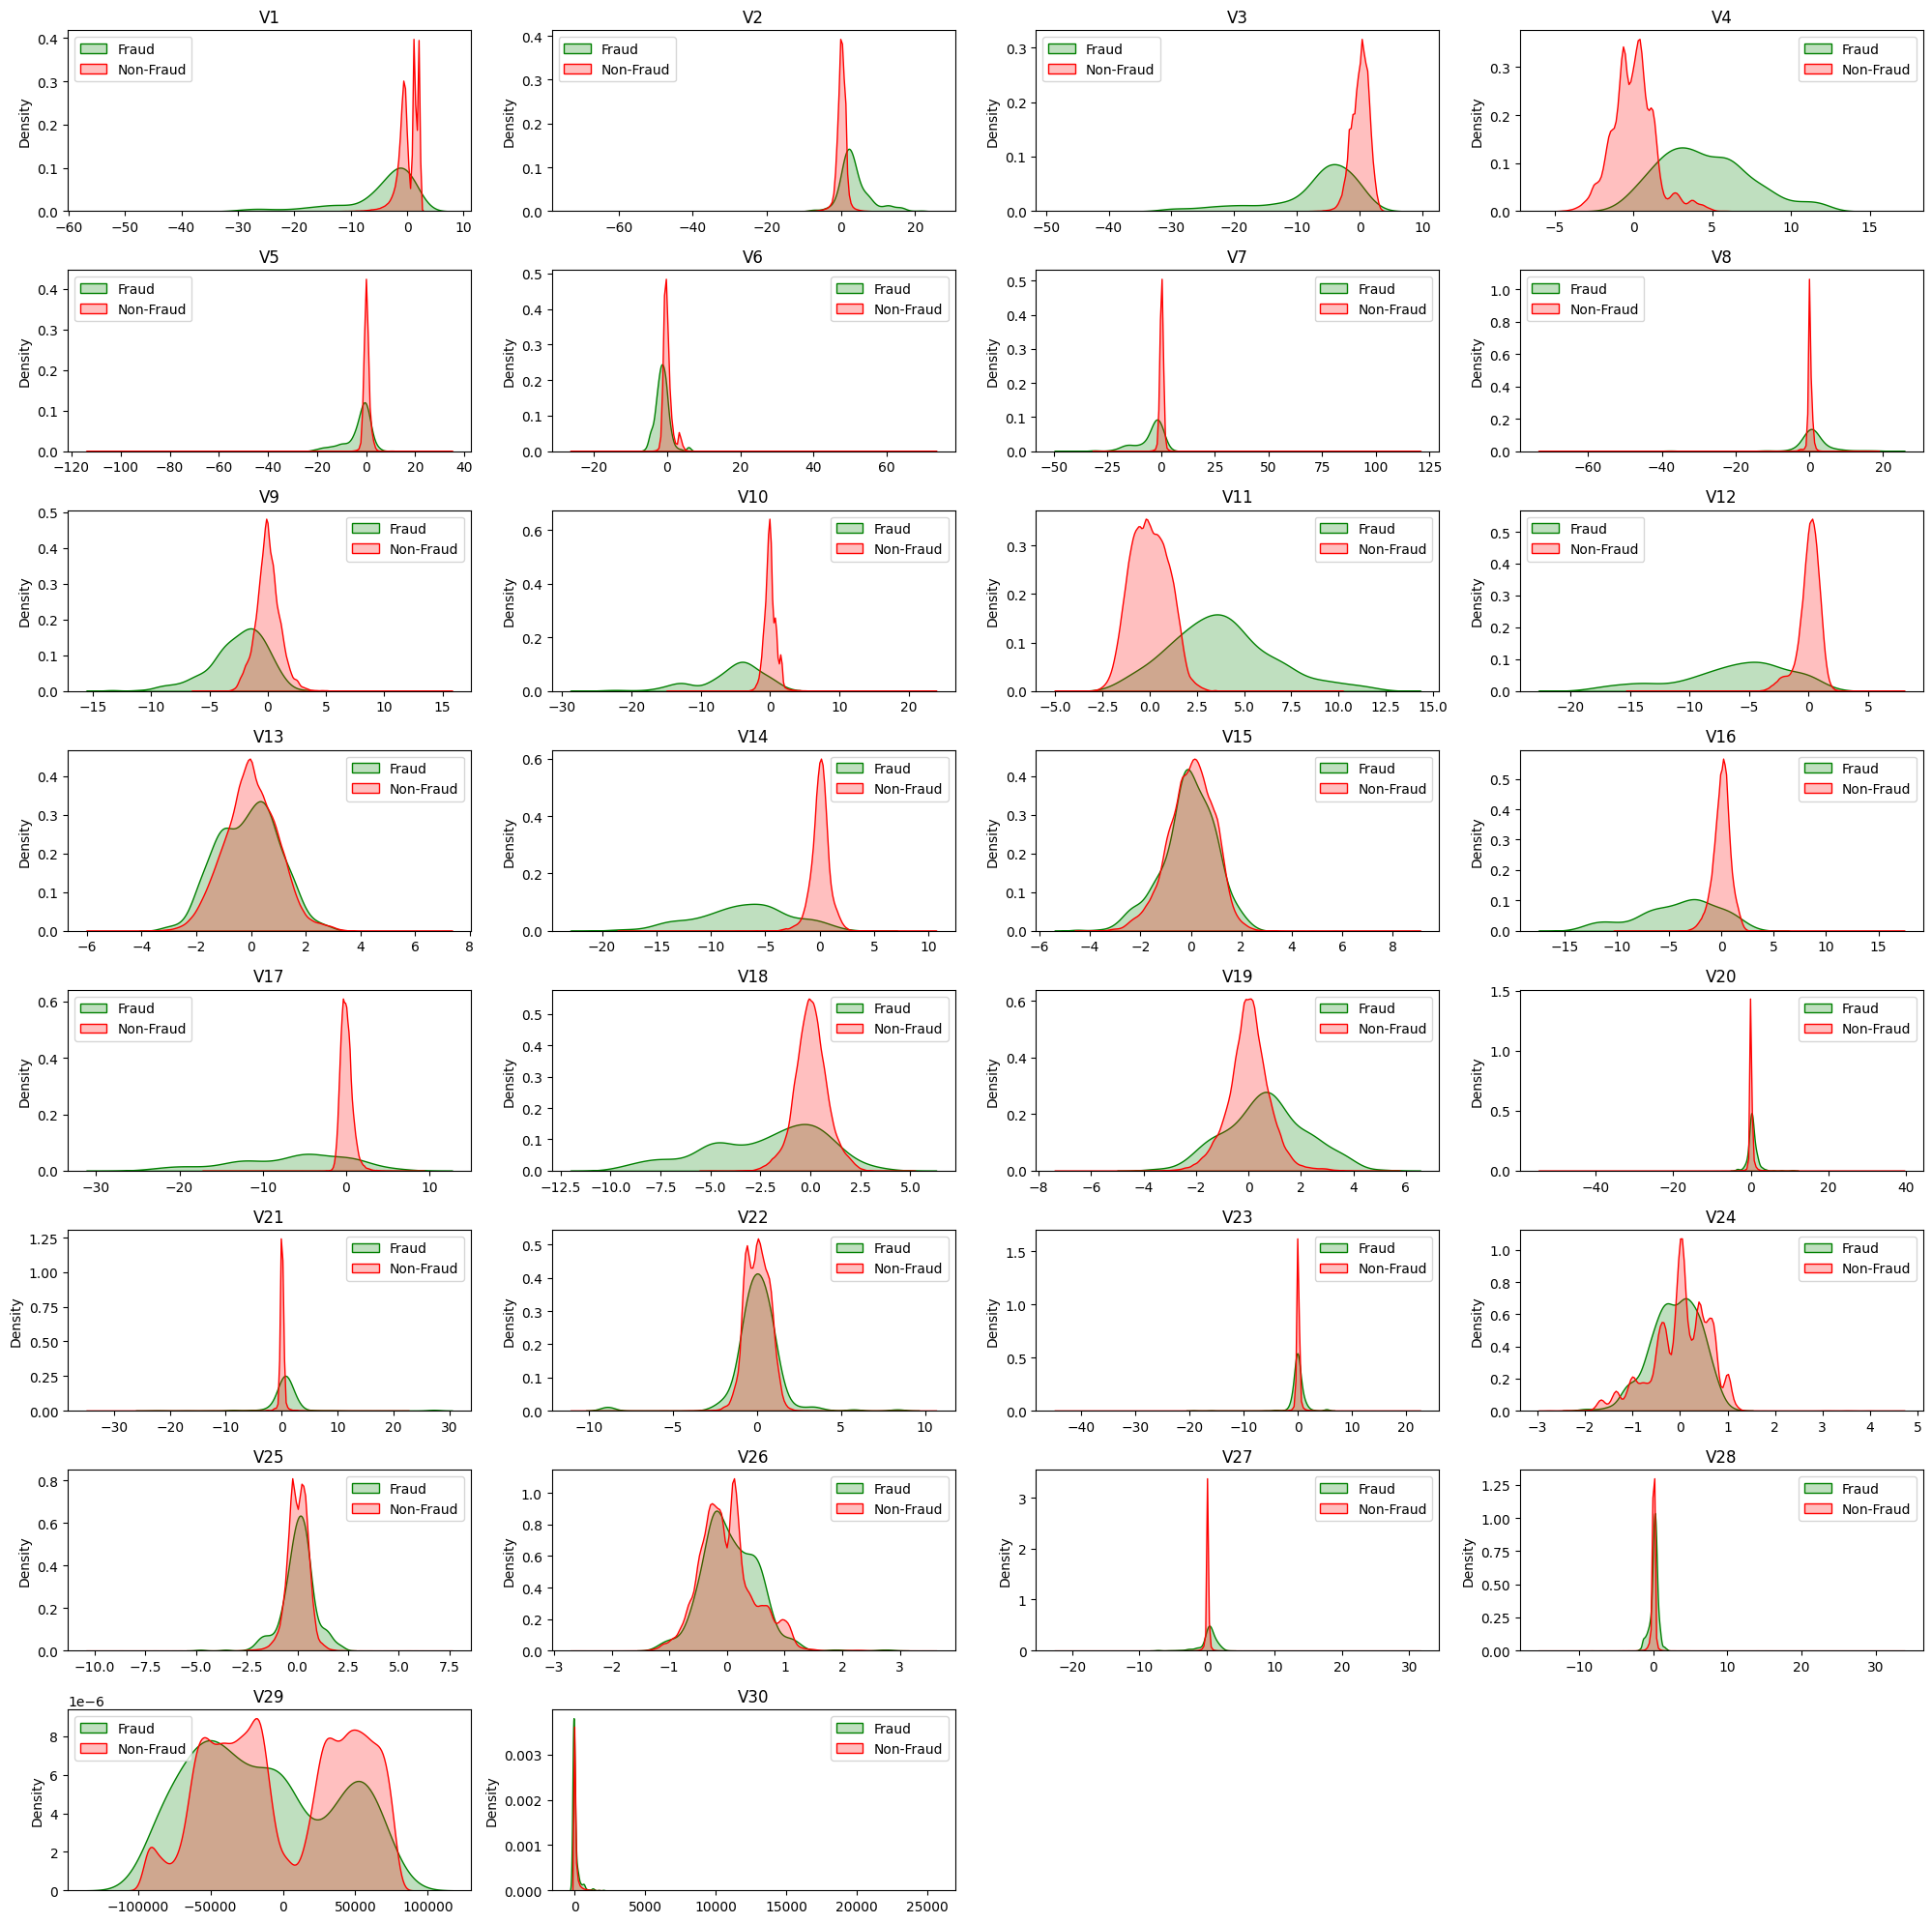

In [ ]:
sample_columns = df.drop('Class', axis = 1).columns


n_cols = 4
n_rows = (len(sample_columns) + n_cols - 1) // n_cols

plt.figure(figsize=(20, 10*2))

for n, col in enumerate(sample_columns, 1):
  plt.subplot(n_rows, n_cols, n)
  sns.kdeplot(df[df['Class'] == 1][col], color='g', label = 'Fraud', fill=True)
  sns.kdeplot(df[df['Class'] ==0][col], color='r', label = 'Non-Fraud', fill=True)
  plt.title(col, fontsize=12)  # 컬럼 이름 추가
  plt.ylabel('Density')
  plt.xlabel('')
  plt.legend()

plt.tight_layout()
plt.show()

# Feature Selection using Z-test

#### **목적**  
특징 선택을 위해 통계적 유의성을 검정하기 위해 Z-test를 수행  
 정상 거래를 모집단으로, 사기 거래를 표본으로 설정하여 각 특징이 통계적으로 유의미한 차이가 있는지 평가  
  이번 검정은 양측 검정(two-tailed test)이며, 유의수준은 0.01로 설정  







#### **시나리오**  
- **모집단**: 정상 거래 (Valid Transactions)  
- **표본**: 사기 거래 (Fraud Transactions)  

# ?? 모집단과 표본을 이렇게 나누는게 말이 되나? 모집단은 정상 거래 + 사기 거래 아닌가?

- **검정 유형**: 양측 Z-test (Two-tailed)  
- **유의수준 (α)**: 0.01  
- **임계값 (Critical Value)**: 2.58  

---

#### **가설 설정**  
- **귀무가설 (H0)**: 차이가 없다 (비유의적)  
- **대립가설 (H1)**: 차이가 있다 (유의적)  

---


#### **판단 기준**  
- **|Z| ≥ 2.58**: 귀무가설 기각 (유의한 차이)  
- **|Z| < 2.58**: 귀무가설 채택 (유의한 차이 없음)  


def ztest(feature):  
  mean = normal[feature].mean()  
  std = fraud[feature].std()  
  zScore = (fraud[feature].mean() - mean) / (std / np.sqrt(sample_size))  
  return zScore  

## ?? ZSCORE 구하는 공식에서 분모는 모집단의 표준편차를 샘플 제곱근으로 나누는 건 여기서는 표본의 표준편차를 샘플 제곱근으로 나눔  



# 필자의 원래 코드   

columns = df.drop('Class', axis = 1).columns  
normal = df[df.Class == 0]  
fraud = df[df.Class == 1]  
sample_size = len(fraud)  

significant_features = []  
critical_value = 2.58   

for feature in columns:  
  z_value = ztest(feature)  
  
  if abs(z_value) >= critical_value:  
    print(f'{feature} is statistically significant (Reject Null Hypothesis, H0).')   
    significant_features.append(feature)  
  else:  
    print(f'{feature} is NOT statistically significant (Fail to Reject Null
     Hypothesis, H0).')   

print('|nSignificant Features:')  
print(significant_features)    


Significant Features:
['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V24', 'V27', 'V28', 'V29', 'V30']


# 저의 생각
1. 먼저 T-TEST가 아닌 Z-TEST를 쓰려고 한 것 같아요 그 이유는 표본으로 쓰려고 하는 사기데이터의 개수가 정상 거래 데이터보다 훨씬 적기 때문에 이걸 고려할 때 Z-TEST가 적합해 보입니다. ( T-TEST는 표본의 크기가 작으면 분산이 커지기 때문)

2. 그리고 T-TEST는 독립된 두 집단의 표본통계량의 차이가 유의미한 지를 구하는 것이고  현재 상황에선 전제 데이터셋(정상 + 사기)을 모집단으로 보는 판단이 맞기 때문에 Z-TEST가 적합해 보입니다. ( 만약 정상거래와 사기 거래 데이터가 둘다 표본집단이었다면 독립된 두 집단을 비교한다는 점에서 T-TEST도 고려해볼 만 하지 않았을까요? )

따라서 필자가 T-TEST와 Z-TEST의 개념을 혼동한 것 같습니다  

# 수정된 Z-TEST 코드

In [ ]:
import numpy as np
fraud = df[df.Class == 1]
def ztest(feature):
    # 전체 거래 (모집단)의 평균과 표준편차
    population_mean = df[feature].mean()
    population_std = df[feature].std()

    # 사기 거래 (표본)의 평균
    sample_mean = fraud[feature].mean()
    sample_size = len(fraud)

    # 표준오차 (Standard Error)
    se = population_std / np.sqrt(sample_size)

    # Z-점수 계산
    zScore = (sample_mean - population_mean) / se
    return zScore

significant_features = []
critical_value = 2.58

for feature in df.drop('Class', axis=1).columns:
    z_score = ztest(feature)
    if abs(z_score) >= critical_value:
        significant_features.append(feature)

print(significant_features)

['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V24', 'V27', 'V28', 'V29', 'V30']


In [ ]:
significant_features.append('Class')
df = df[significant_features]

# 피쳐 변형

### Feature Transformation for Anomaly Detection

---

#### **역할**  
특징 변환은 이상치 탐지 알고리즘의 성능을 향상시키는 데 중요한 역할을 함  
 **많은 알고리즘은 데이터가 가우시안(정규) 분포를 따른다고 가정하기 때문에**, 특징이 왜곡(skewed)되거나 서로 다른 스케일을 가지면 모델이 정상 데이터와 이상치를 구분하는 데 어려움을 겪을 수 있음  
  이로 인해 정상 데이터를 이상치로 잘못 분류하거나 실제 이상치를 놓치는 문제가 발생할 수 있음  


---

#### **왜곡 문제 해결**  
히스토그램 플롯을 통해 여러 특징이 심각하게 왜곡된 것을 확인했다. 이를 해결하기 위해 **로그 변환 (Log Transformation)**을 적용할 계획이다. 이 변환은 다음과 같은 장점이 있다:

- **분산 안정화**  
- **왜도 감소 및 대칭성 증가**  
- **데이터 해석 용이성 개선**  

이와 같은 변환을 통해 모델이 정상 데이터와 이상치를 보다 정확히 구분할 수 있도록 하며, 탐지 과정의 신뢰성을 높일 수 있다.

---

#### **예시**  
일부 특징 (예: V20, V25)은 정상 및 사기 거래의 데이터 분포가 겹쳐서 두 클래스를 구분하는 데 어려움을 주고 있다. 이러한 특징은 분류 성능에 부정적인 영향을 줄 수 있다.  


In [ ]:
features = df.columns[:-1]
df_transformed = df.copy()

def log_transform_skewed(column) :
  transformed = np.where(column >= 0, np.log1p(column), -np.log1p(-column))
  return transformed

skewness_before = df.skew()

for col in features:
  if abs(df[col].skew()) > 0.75:
    df_transformed[col] = log_transform_skewed(df[col])

skewness_after = df_transformed.skew()

skewness_comparison = pd.DataFrame({
    'Skewness Before': skewness_before,
    'Skewness After' : skewness_after
})

skewness_comparison

,Skewness Before,Skewness After
V1,-3.280667,-0.364893
V2,-4.624866,-0.310128
V3,-2.240155,-0.315192
V4,0.676292,0.676292
V5,-2.425901,0.139077
V6,1.826581,0.804345
V7,2.553907,-0.112666
V8,-8.521944,-0.912642
V9,0.554680,0.554680
V10,1.187141,0.420549


- 로그 변환 후, 더 이상 왜도는 관찰되지 않음

### **필자가 로그변환을 선택한 이유 추측**

---

- **실시간 이상 탐지에서 빠른 계산 속도와 단순한 해석이 더 중요한 요소였을 가능성 큼**  
- **박스-콕스 변환**은 최적의 **λ (람다)**를 찾는 데 추가적인 연산이 필요하므로,  
- **속도와 단순성**이 중요한 프로젝트에서는 다소 부담스러울 수 있음  


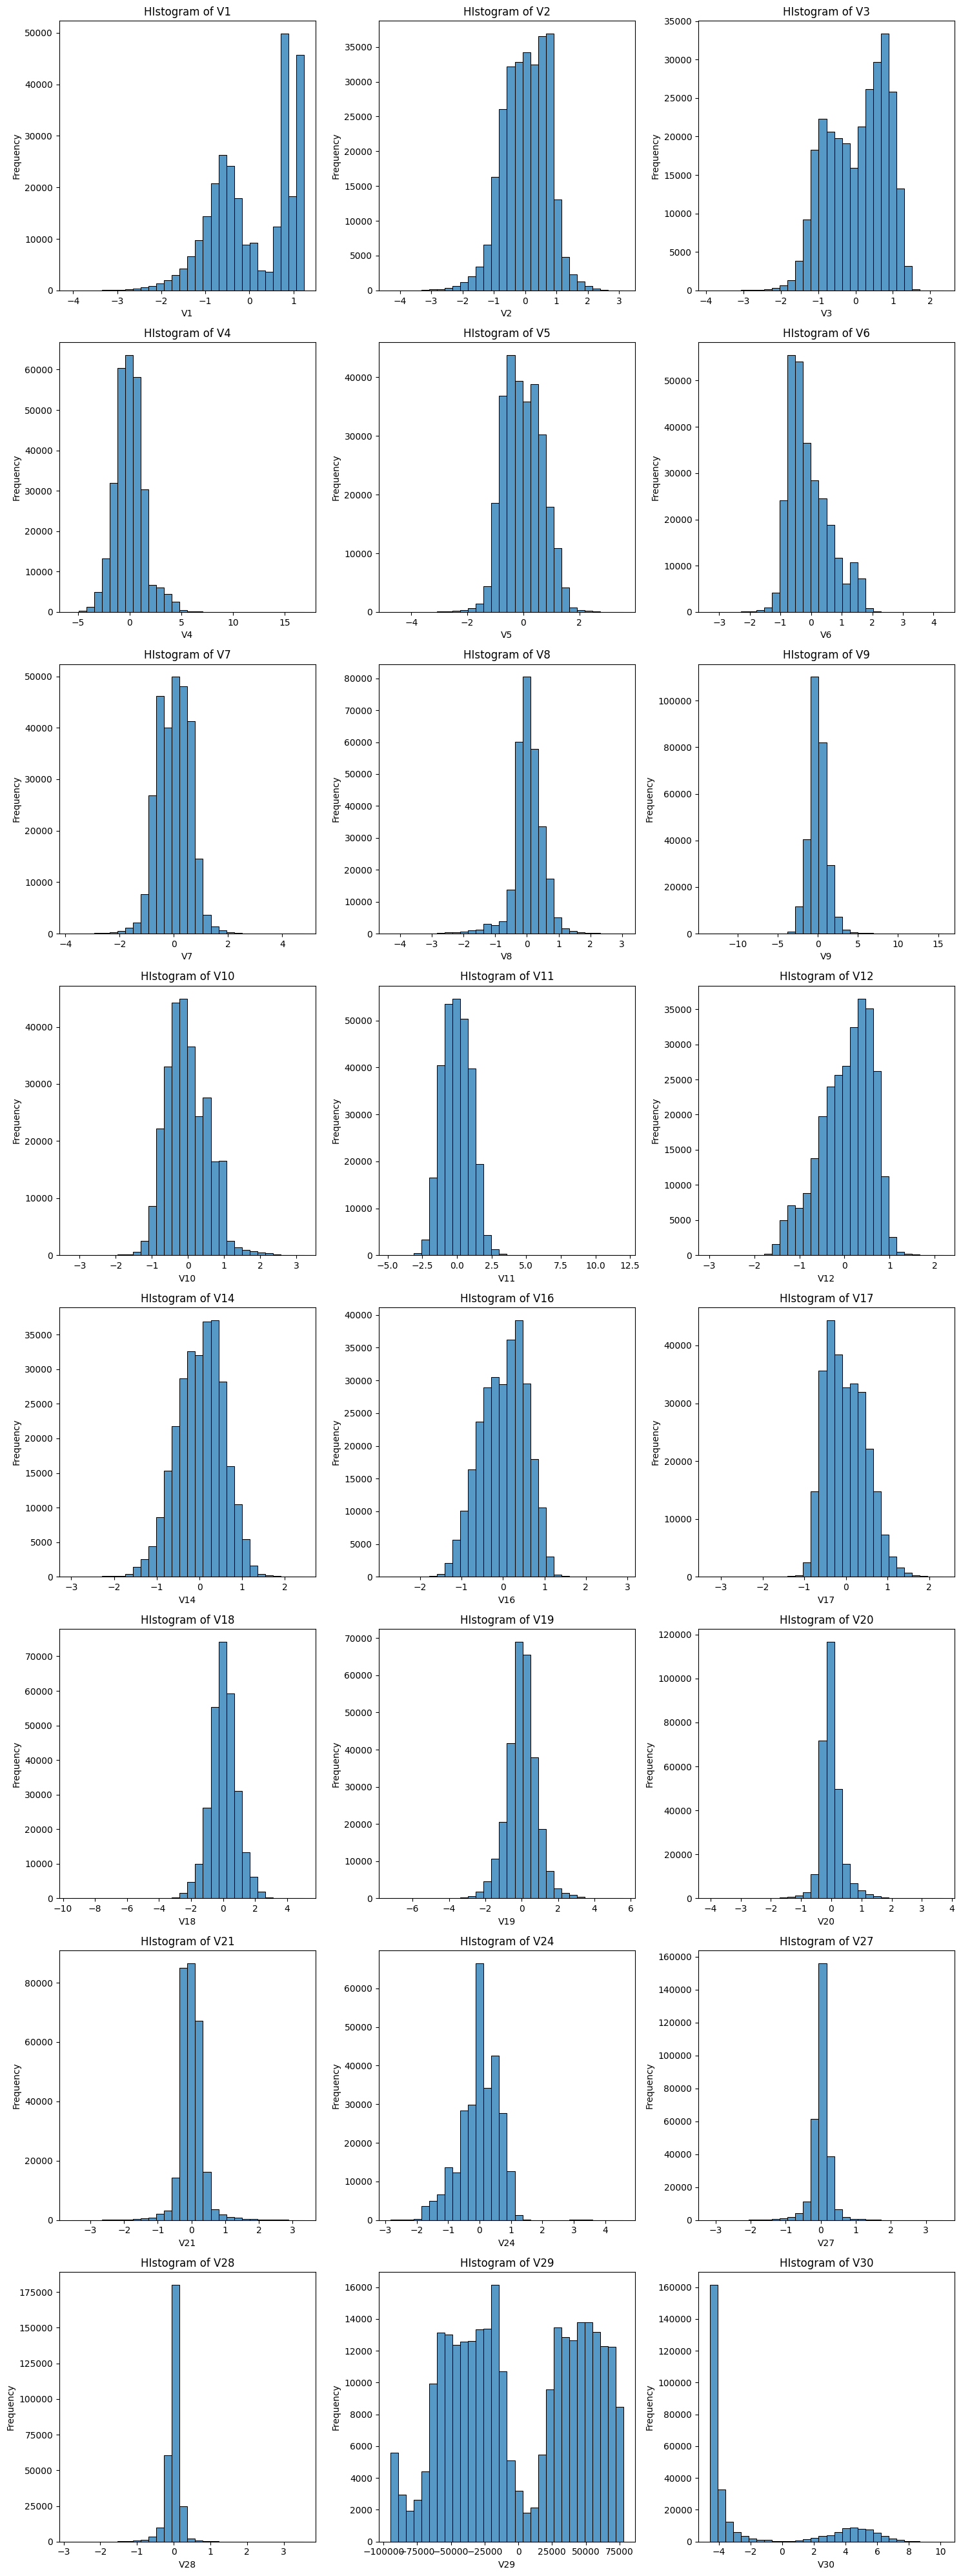

In [ ]:
features = df.columns[:-1]
fig, axes = plt.subplots(8,3,figsize = (15, 40))

axes = axes.flatten()

for i, feature in enumerate(features):
  sns.histplot(df_transformed[feature], ax= axes[i], kde=False, bins = 30)
  axes[i].set_title(f'HIstogram of {feature}')
  axes[i].set_xlabel(feature)
  axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# 피쳐 스케일링

In [ ]:
X = df_transformed[features]
y = df_transformed.Class

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


<a id="1"></a>
# <div style="text-align:center; border-radius:25px 70px; padding:9px; color:white; margin:0; font-size:150%; font-family:Pacifico; background-color:#0566D5; overflow:hidden"><b>Isolation Forest</b></div>

![iso](https://machinelearninggeek.com/wp-content/uploads/2020/10/image-78.png)

### **🌲 Isolation Forest**

---

Isolation Forest는 **비지도 학습** 기반의 **이상치 탐지 알고리즘**임.  
이 알고리즘은 **Isolation Trees**라는 이진 트리의 앙상블을 구성하여 데이터를 분리하는 방식으로 동작함.  
**이상치 (Anomaly)**는 **일반 데이터**에 비해 더 적고, 분포가 다르기 때문에  
**더 짧은 경로 길이**를 가지는 특성을 활용하여 **이상치**를 식별함.  

---

#### **작동 원리**  
- **무작위 분할 (Random Splits)**:  
  - Isolation Forest는 **특성을 무작위로 선택**하고 **무작위 값**을 기준으로 데이터를 분리함  
  - **이상치**는 일반적으로 **적고 특이**하기 때문에 더 적은 분할로도 쉽게 분리될 수 있음  

- **경로 길이 (Path Lengths)**:  
  - **이상치**는 **일반 데이터**보다 평균 경로 길이가 짧은 경향이 있음  
  - 이러한 **경로 길이**를 바탕으로 **이상치 점수**를 부여하여 **이상치**를 식별함  

---

#### **장점**  
- **대규모 데이터에 효율적**  
  - Isolation Forest는 **빠르고 확장성**이 뛰어나 **고차원 데이터셋**에서도 성능이 우수함  
- **데이터 분포 가정 없음**  
  - 기본적으로 **데이터의 분포를 가정하지 않으므로** 다양한 유형의 데이터에 적용 가능함  
- **고차원 데이터 처리 가능**  
  - **고차원 데이터**에서 잘 동작하며, 이는 많은 다른 **이상치 탐지 알고리즘**이 처리하기 어려운 점임  

---

#### **제한점**  
- **복잡한 패턴 감지 한계**  
  - 무작위 분할을 사용하기 때문에 복잡한 패턴이나 관계를 찾는 데는 한계가 있음  
- **유사 이상치 탐지 어려움**  
  - 일반 데이터와 매우 유사한 이상치는 **정확하게 감지하기 어려울 수 있음**  

---

#### **요약**  
- Isolation Forest는 **대규모, 고차원 데이터**에서 효율적인 **이상치 탐지 기법**으로,  
- **데이터 분포**에 대한 가정 없이 빠르고 확장 가능하다는 점에서 많은 장점을 가짐  
- 다만, **복잡한 패턴**을 다루는 데는 다소 한계가 있음  


In [ ]:
iso_forest = IsolationForest(contamination = 0.05, random_state=101) # contamination=0.05: 전체 데이터의 약 5%를 이상치로 간주하겠다는 의미

iso_preds = iso_forest.fit_predict(X_scaled)

iso_preds = [ 1 if x == -1 else 0 for x in iso_preds] # Isolation Forest는 기본적으로 -1을 이상치로, 1을 정상 데이터로 분류함

print(classification_report(y, iso_preds))
roc_auc = roc_auc_score(y, iso_preds)
print('ROC AUC Score: ', roc_auc)

              precision    recall  f1-score   support

           0       1.00      0.95      0.97    284315
           1       0.03      0.85      0.06       492

    accuracy                           0.95    284807
   macro avg       0.51      0.90      0.52    284807
weighted avg       1.00      0.95      0.97    284807

ROC AUC Score:  0.9025234806979375


**신용카드 사기 탐지의 경우**
일반적으로 신용카드 사기 데이터셋은 0.001 ~ 0.01 정도로 설정

**현재 설정 (0.05)**는 실제 사기 비율보다 너무 높을 수 있음

실제 Credit Card Fraud 데이터셋에서 사기 비율은 약 0.17% (0.0017) 수준임

### contamination 0.05를 사용한 결과  ==>   Precision (정밀도): 0.03 ㅋㅋ

- 현재 모델은 Recall은 높지만, Precision이 극단적으로 낮아 실제 이상치 탐지 성능이 매우 부족함

- 모델의 Threshold와 Hyperparameter를 최적화하여 Precision을 높이는 방향으로 수정 필요




In [ ]:
def plot_confusion_matrix(y_true, y_pred, title = 'Confusion Matrix'):

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot =True, fmt= 'g', cmap = 'Blues')

    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
    plt.yticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])

    plt.show()

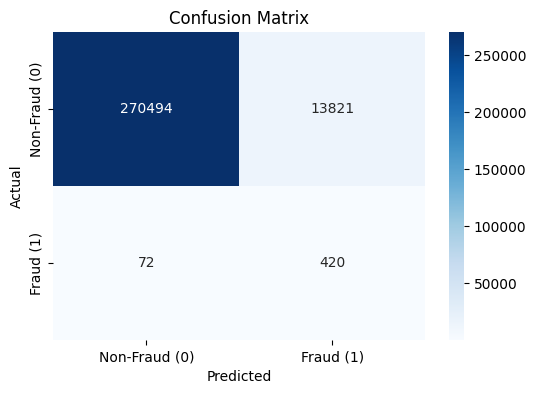

In [ ]:
plot_confusion_matrix(y, iso_preds)

# One-Class SVM

# Support Vector Machine (SVM)

SVM(Support Vector Machine)은 주로 분류(Classification)와 회귀(Regression) 문제에 사용되는 지도 학습 알고리즘임. 데이터 포인트를 서로 다른 클래스로 구분하거나 연속적인 값을 예측하기 위해 최적의 초평면(Hyperplane)을 찾는 게 목표임. 다른 클래스 사이의 마진을 최대화하여 모델의 일반화 성능을 높이는 방식으로 동작함.

## SVM 주요 특징
- **선형 및 비선형 분류**  
  - 선형으로 구분 가능한 데이터뿐만 아니라 커널(Kernel) 함수를 이용해 고차원 특징 공간으로 매핑하여 비선형으로 구분되는 데이터도 처리할 수 있음.
- **고차원 데이터에서 효과적**  
  - 많은 수의 특징을 가진 고차원 데이터에서도 효과적으로 동작함.
- **계산 복잡성**  
  - 강력한 모델이지만, 학습 시 계산 복잡도가 높아서 데이터가 큰 경우 시간이 오래 걸릴 수 있음

---

# One-Class SVM

One-Class SVM은 SVM의 변형 모델로, 주로 이상치(Anomaly) 탐지에 사용됨. 일반적인 데이터의 경계를 학습하여 그 경계를 벗어난 데이터 포인트를 이상치로 분류하는 방식임. 고차원 데이터에서 전통적인 이상치 탐지 방법이 어려운 경우 특히 유용함.

## One-Class SVM 주요 특징
- **경계 탐지**  
  - 정상 데이터의 경계를 학습하여 이 경계를 벗어난 데이터를 이상치로 판단함.
- **고차원 데이터에서 효과적**  
  - 고차원 특징 공간에서도 전통적인 방법보다 효과적으로 이상치를 탐지할 수 있음.
- **계산 비용**  
  - 데이터에 노이즈가 많은 경우 오탐률이 높아질 수 있으며, 큰 데이터셋에서는 계산 비용이 많이 들 수 있음.


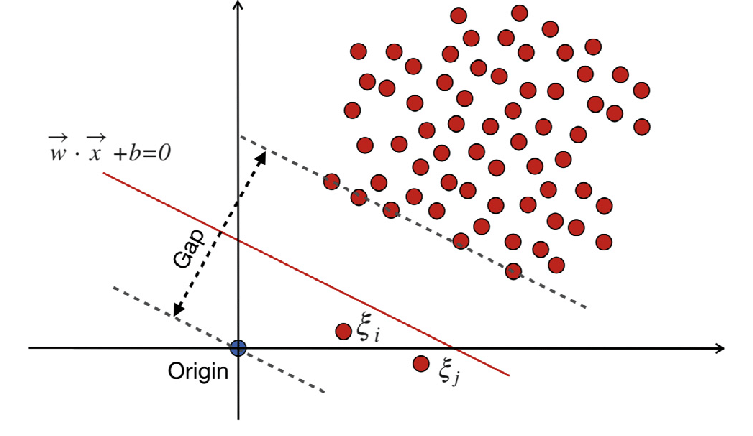

# 데이터 크기 이슈로 안돌아감

In [ ]:
oc_svm = OneClassSVM(kernel = 'rbf', gamma = 0.001, nu = 0.05)

# rbf (Radial Basis Function) 커널 사용
# gamma: 데이터의 영향 범위를 결정하는 파라미터 (작을수록 더 넓은 범위, 클수록 좁은 범위)
# nu: 모델이 이상치로 분류할 수 있는 데이터 비율 (0~1 사이의 값)


svm_preds = oc_svm.fit_predict(X_scaled)

svm_preds = [1 if x == -1 else 0 for x in svm_preds]

print(classification_report(y_svm_preds))
roc_auc = roc_auc_score(y, svm_preds)
print('ROC AUC Score: ', roc_auc)
print('Confusion Matrix:')

KeyboardInterrupt: 

**gamma** = 두 데이터 포인트 사이의 유사도를 계산할 때 얼마나 가까운 데이터에만 민감하게 반응할지를 결정하는 중요한 파라미터

# Local Outlier Factor

# Local Outlier Factor (LOF)

LOF (Local Outlier Factor)는 비지도 학습 기반의 이상치 탐지 알고리즘으로, 각 데이터 포인트의 **지역 밀도(Local Density)**를 주변 데이터와 비교하여 이상도를 평가하는 방법임. 즉, 데이터 포인트가 주변 이웃에 비해 얼마나 밀도가 다른지에 따라 이상치 여부를 결정함.

---

## 🔎 **LOF 작동 원리**

- **지역 접근 가능성 밀도 (Local Reachability Density)**  
  - 각 데이터 포인트의 지역 밀도를 계산하여 얼마나 고립되어 있는지 측정함.  
  - 이 밀도는 데이터 포인트가 얼마나 다른 점들과 가깝게 모여 있는지를 나타냄.  

- **이상치 점수 (LOF Score)**  
  - 밀도 편차가 큰 데이터 포인트는 높은 LOF 점수를 받음.  
  - LOF 점수가 높을수록 주변 이웃들에 비해 고립되어 있어 이상치일 가능성이 큼.  

---

## 🗝️ **LOF 주요 특징**

- **다양한 밀도에 효과적**  
  - 서로 다른 밀도를 가진 데이터 클러스터에서도 효과적으로 이상치를 탐지할 수 있음.  

- **지역적 관점**  
  - 전역적인 밀도보다는 국소적인 밀도를 비교하여 보다 정교한 이상치 탐지가 가능함.  
  - 데이터가 복잡한 구조를 가지거나 비균일하게 분포된 경우에도 잘 작동함.  

- **데이터 분포 가정 없음**  
  - 전통적인 통계 기반 방법과 달리 데이터의 기본 분포에 대한 가정 없이 작동함.  

---

## ⚠️ **주의점 (Considerations)**

- **이웃의 수에 민감함**  
  - `n_neighbors` 파라미터에 따라 성능이 크게 달라질 수 있음.  
  - 너무 작으면 노이즈에 민감해지고, 너무 크면 지역 밀도의 차이가 반영되지 않음.  

---

## 📌 **사용 사례 (Use Cases)**

- **복잡한 데이터 구조**  
  - 다양한 밀도를 가진 클러스터 구조에서의 이상치 탐지에 유리함.  

- **클러스터 내 이상치 탐지**  
  - 데이터가 복잡하고 불규칙한 구조를 가지는 경우에도 효과적임.  

---

LOF는 데이터가 균일하지 않거나 복잡한 구조를 가진 경우 특히 유용한 이상치 탐지 기법임. 주로 금융 사기 탐지, 네트워크 이상 탐지, 산업 기기 오류 탐지 등 다양한 분야에서 사용됨. 😊


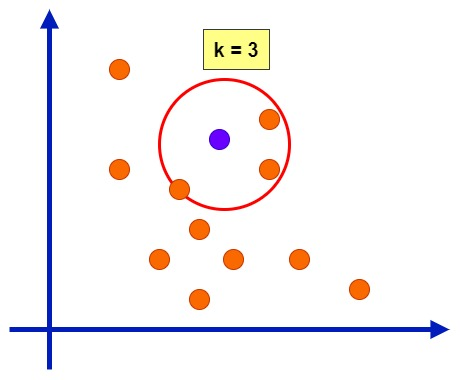

In [ ]:
lof = LocalOutlierFactor(n_neighbors = 10,  contamination = 0.05)

lof_preds = lof.fit_predict(X_scaled)

lof_preds =  [1 if x == -1 else 0 for x in lof_preds]

print(classification_report(y, lof_preds))
roc_auc = roc_auc_score(y, lof_preds)
print('ROC AUC Score: ', roc_auc)
print('Confusion Matrix:')
print(confusion_matrix(y, lof_preds))

In [ ]:
plot_confusion_matrix(y, lof_preds)

# DBSCAN

## DBSCAN이란?  

DBSCAN이란 Density-Based Spatial Clustering of Applications with Noise의 줄임말  
영어 표현 그대로 밀도 기반 클러스터링 방법  


전제는 다음과 같음  
- 어떤 데이터가 특정 클러스터에 속할 경우, 클러스터 내의 다른 데이터들과 가까운 위치에 있어야 한다   


DBSCAN은 **1. 다른 많은 데이터와 2. 가까운 위치** 이 두 가지를 통해 클러스터를 구분함  
  
  그렇다면 얼마나 많은 데이터와 얼마나 가까운 위치에 있어야 하나의 클러스터로 분류할까?  

  이 두가지는 모델 학습 시 임의로 지정해 줘야함  

  얼마나 가까운 위치에 데이터가 있어야 하는지 ==> **반경(Radius)**  
  반경 내에 얼마나 많은 데이터가 있어야 하는지 ==> **최소 데이터 개수(Minimum Points)**   

### 과정  

먼저, 특정 데이터에서 지정한 반경 내애 몇 개의 데이터가 포함되는지 탐색  

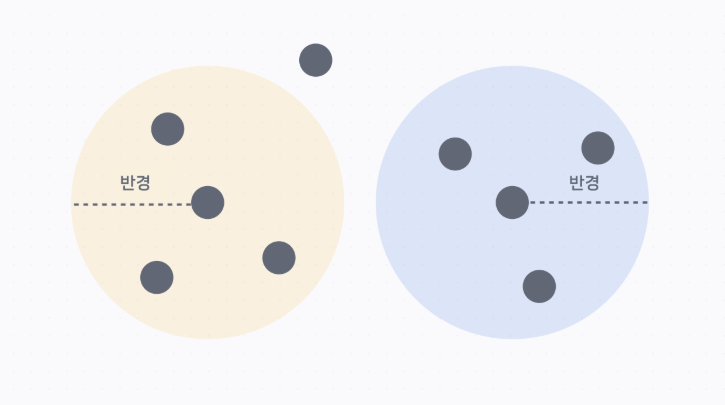




정해진 반경 내에 최소 데이터 개수가 포함되면 하나의 클러스터로 묶음.  
 만약에, 최소 데이터 개수가 4개라고 하면 아래 이미지에는 두 개의 클러스터가 생기게 됨.

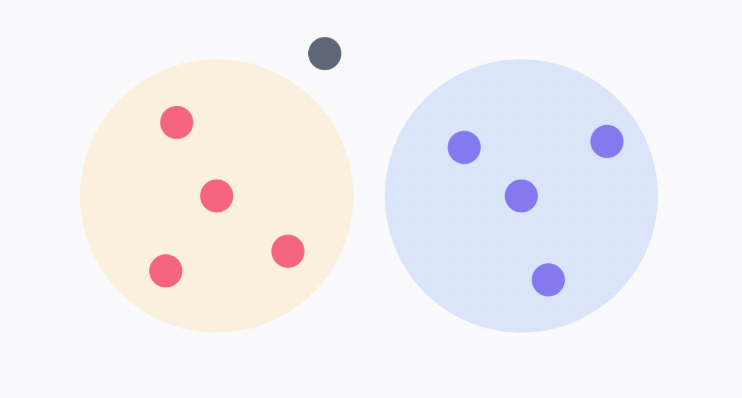


만들어진 두 개의 클러스터의 경계에 있는 데이터들에서 그린 반경이 서로 겹치는 경우가 생길 수 있음.  

그럴 경우에는 두 클러스터를 하나로 묶음  

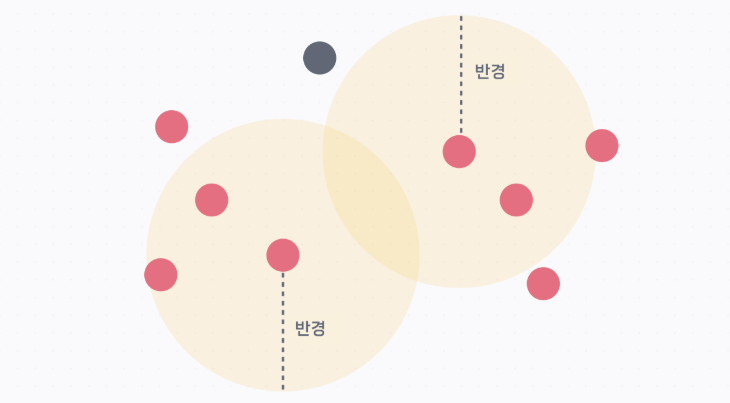
)


조건에 만족하지 못하고 어떠한 클러스터에도 포함되지 못한 데이터는 이상치(Outlier)가 됨  

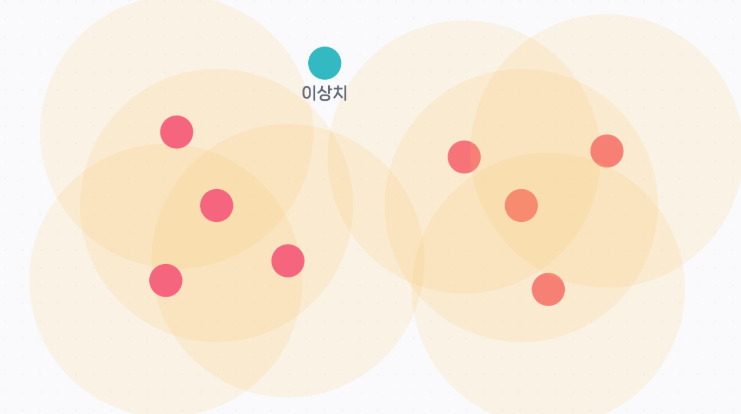

   

k-means는 이상치가 Centroid 위치에 관여하면서 결과에 영향을 끼쳤음  
 DBSCAN은 기준에 포함되지 못하는 데이터를 제외하기 때문에 이상치에 강건(Robust)한 방법임  

또, 데이터의 밀도에 따라 클러스터를 만들기 때문에 복잡하거나 기하학적인 형태를 가진 데이터셋에 효과적임  

반면, 고차원 데이터일수록 데이터 간 밀도를 계산하기 어렵고 연산이 많아져 학습속도가 느려질 수 있다는 단점이 있음

In [ ]:
dbscan = DBSCAN(eps = 0.5, min_samples = 5)

dbscan_preds = dbscan.fit_predict(X_scaled)

dbscan_preds = [ 1 if x == -1 else 0 for x in dbscan_preds]

print(classification_report( y, dbscan_preds))
roc_auc = roc_auc_score(y, dbscan_preds)
print('ROC AUC ScoreL ', roc_auc)
print('Confusion Matrix:')
print(confusion_matrix(y, dbscan_preds))

In [ ]:
plot_confusion_matrix(y, dbscan_preds)

# 결론

# 📊 **Fraud Detection Model Analysis**

대부분의 모델은 **"사기 (fraud, class 1)"** 거래를 최대한 많이 잡기 위해 높은 재현율 (Recall)에 초점을 맞춤. 하지만 이는 정상 거래를 사기로 잘못 분류하는 **"오탐지 (False Positive)"**가 많아지는 단점이 있음. ⚠️ 이런 트레이드오프는 사기 탐지에서 흔한 문제이며, **재현율**과 **정밀도**를 균형 있게 맞추는 것이 핵심 목표임. ⚖️

---

## 📈 **Model Performance Breakdown**

### 🔗 **DBSCAN**  
- **성과:** 사기 탐지에서 92%의 높은 재현율을 기록했음 🚨  
- **문제점:**  
  - 대부분의 거래를 사기로 분류하여 **오탐률**이 매우 높음  
  - 전체 거래 중 **0.2%**만 사기임에도 불구하고 많은 정상 거래를 잘못 플래그함  
  - 결과적으로 높은 비용 💸과 고객 불편이 발생할 가능성이 큼  
- **결론:** 높은 재현율에도 불구하고 **실용성이 떨어지는** 접근 방식임 ❌  

---

### 🔄 **One-Class SVM과 Isolation Forest**  
- **성과:**  
  - 약 87%의 사기를 잡아내며 🔍  
  - **오탐**을 줄이는 데 더 효과적임  
- **장점:**  
  - 사기를 효과적으로 탐지하면서도 불필요한 중단이 적음  
  - 보다 균형 잡힌 접근법 ✅  
- **결론:** **현실적인 사기 탐지** 모델로 더 적합함 🚀  

---

## 📌 **Key Takeaways**

- 높은 재현율은 중요하지만, **정밀도**가 낮으면 **비용**과 **고객 불편**이 크게 증가할 수 있음.  
- **DBSCAN**은 극단적으로 높은 재현율을 제공하지만, 실용성이 떨어짐.  
- **One-Class SVM**과 **Isolation Forest**는 더 균형 잡힌 결과를 제공하여 실제 비즈니스 환경에서 더 적합함.  

---

## ✅ **Recommendations**

- **재현율**과 **정밀도**의 균형을 맞추는 데 초점을 맞출 것  
- **오탐 비용**을 고려하여 고객 만족도와 운영 효율성을 함께 고려할 것  
- **하이브리드 접근**이나 **앙상블 기법**을 사용하여 재현율과 정밀도 간의 트레이드오프를 최적화할 것  

---